# 5.4 Visualizing what convnets learn

## It's often said that deep-learning models are 'black boxes': learning representations that are difficult to extract and present in a human-readable form.

## This is partially true for certain types of deep-learning models, but it's not true for convnets: The representations learned by convnets are highly amenable to visualization, in large part because they're *representations of visual concepts*

## We will cover three of the most accessible and useful techniques developed for visualizing and interpreting these representations:

### 1) Visualizing intermediate convnet outputs (intermediate activations) ---- understand how successive convnet layers transform their input and get a first idea of individual convnet filters;

### 2) Visualizing convnets filters ---- understand precisely what visual pattern or concept each filter in a convnet is receptive to;

### 3) Visualizing heatmaps of class activation in an image ---- understand which parts of image were identified as belonging to a given class, thus allowing you to localize objects in images

### For the first method --- activation visualization --- we use the small convnet that we trained from scratch on the dogs-versus-cats classification problem in 5.2. For the next two methods, we use VGG16 introduced in 5.3.

## 5.4.1 Visualizing intermediate activations

### Visualizing intermediate activations consists of displaying the feature maps that are output by various convolutional and pooling layers in a network, given a certain input.

### The output of a layer is often called its *activation*  ------- the output of the activation function;

### This tells you how an input is decomposed into the different filters learned by the network. We want to visualize feature maps with 3 dimensions: width, height, and depth (channels);

### Each channel encodes relatively independent features, so the proper way is to visualize these feature maps  by independently plotting the contents of every channel as a 2D image.

### Let's start by loading the model saved in section 5.2:

In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')

Using TensorFlow backend.
W0704 00:09:01.282184 140209473054464 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 00:09:01.308341 140209473054464 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 00:09:01.342972 140209473054464 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 00:09:01.445970 140209473054464 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Plea

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Then we get an input image of a cat --- not part of the images the network was trained on

In [3]:
img_path = '/input/cats_and_dogs_small/test/cats/cat.1700.jpg'

# process the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


### Let's display the picture

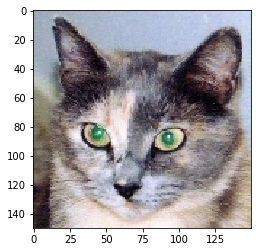

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

### In order to extract feature maps we want to visualize, we create a Keras model that takes batches of images as input and outputs the activations of all convolutonal and pooling layers.

### To do this, we will use the Keras class *Model*: it allows models with multiple outputs, unlike *Sequential*

In [6]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # the output of the top 8 layers (conv & pool)
activation_model = models.Model(input = model.input, outputs = layer_outputs)

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  after removing the cwd from sys.path.


### When fed an image input, this model returns the values of the layer activations in the original model. This is the first time we see a multi-output model in this book: until now, the models we have seen all had exactly one input and one output;

### In general sense, a model can have any number of inputs and outputs.This  one has one input and eight outputs: one output per layer activation.

In [7]:
# Run the model in predict mode;
# returns a list of 5 Numpy arrays, one array per layer activation
activations = activation_model.predict(img_tensor)

### e.g.  this is the activation of the first convolution layer for the cat image input:

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


### It's a 148 &times; 148 feature map with 32 channels. Let's try plotting the fourth channel of the activation of the first layer of the original model

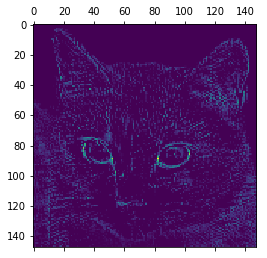

In [9]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap = 'viridis')

### This channel appears to encode a diagonal edge detector. Let's try the eighth channel ---- but note that your own channels may vary, because the specific filters learned by convolutional layers aren't deterministic 

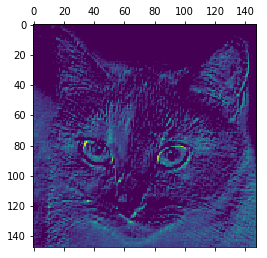

In [10]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap = 'viridis')

### This one looks like a 'bright green dot' detector, useful to encode cat eyes.
### Now let's plot a complete visualization of all the activations in the network: extract and plot every channel in each of the eight activation maps, then stack the results in one big image tensor,  with channels stacked side by side

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


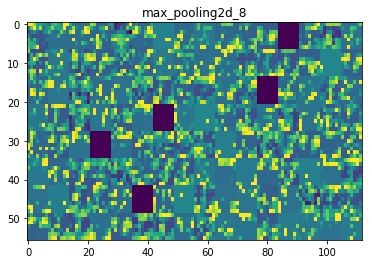

In [15]:
# visualize every channel in every intermediate activation

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # name of layers, so you can have them as part of the plots

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = int(layer_activation.shape[-1]) # number of features in the feature map;
    
    size = layer_activation.shape[1] # feature map has shape (1, size, size, n_features)
    
    n_cols = int(n_features // images_per_row) # tile the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # tile each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row] # every filter
            
            # post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') # limit the range
            
            # display the grid
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

### There are several things to note here:
### 1) The first layer acts as a collection of various edge detectors,, at which the activations retain almost all of the information present in the initial picture;
### 2) As we go higher, the actiivations become increasingly abstrct and less visually interpretable. They begin to encode higher-level concepts such as 'cat ear'.  ---- Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image
### 3) The sparsity of the activations increases with the depth of the layer: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank, which means the pattern encoded by the filter isn't found in the input image

### We have evidenced an important universal characteristic of the representations learned by deep neural networks:

## The features extracted by a layer become increasingly abstract with the depth of the layer.
### ------- The activations of higher layers carry less and less information about the specific input being seen, and more and more information about the target (in this case, the class: cat & dog)

### A deep neural network effectively acts as an *information distillation pipeline*: with raw data going in (this case, RGB pictures) and being repeatedly transformed, so that irrelevent information is filtered (e.g. specific visual appearance of the image), and useful information is magnified and refined (e.g. class of image)

### This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were seen, but can't remember the specific appearance of these objects.
### Our brain has learned to completely abstract its visual input --- to transform it into high-level visual concepts while filtering out irrelevant visual details ---- making it tremendously difficult to remember how things around you exactly looks like.

## 5.4.2  Visualizing convnet filters

### Another easy way to inspect the filters learned by convnets is to display the visual patterns that each filter is meant to respond to. 

### This can be done with *gradient ascent in input space*: applying *gradient descent* to the value of the input image of a convnet so as to *maximize* the response of a specific filter, starting from a blank input image. The resulting input image will be one that the chosen filter is maximally responsive to.

### The process is: build a loss function that maximizes the value of a given filter in a given convolutional layer, and we use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value.

### For instance, here's a loss for the activation of filter 0 in the layer block3_conv1 of the VGG16 network:

In [1]:
from keras.models import load_model

model = load_model('conv_base.h5')

Using TensorFlow backend.
W0704 18:52:30.538920 140367904720640 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 18:52:30.569087 140367904720640 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 18:52:30.612323 140367904720640 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0704 18:52:31.006089 140367904720640 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pl

In [2]:
# define the loss tensor for filter visualization


from keras  import backend as K


layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

### To implement gradient descent, we'll need the gradient of this loss with respect to the model's input. To do this, we use the 'gradients' function packaged with the *backend* module of Keras

In [3]:
grads = K.gradients(loss, model.input)[0]
# The call to gradients returns a list of tensors(of size 1 in this case);
# Hence, we index 0 to keep the first element

### A trick to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (square root of the average of the square of the values in the tensor).  This ensures the magnitude of the updates done to the input image is always within the same range.

In [4]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #add 1e-5 before dividing to avoid accidentally diving by 0

### Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image.
### We define a *iterate* functionu using Keras backend: to take a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value

In [5]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

### At this point, we can define a loop to do stochastic gradient descent:

In [6]:
# starts from a gray image with some noise

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1  # magnitude of each gradient update

# run gradient ascent for 40 steps
for i in range(40):
    loss_value, grads_value = iterate([input_img_data]) # compute the loss value and gradient value
    
    input_img_data += grads_value * step # adjust the input image in the direction that maximizes the loss

### The resulting tensor is a floating-point tensor of shape (1, 150, 150, 3), with values that may not be integers within [0, 255]. Hence we need to post-process this tensor into a displayable image.

### You can do it with the following straightforward utility function:

In [7]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1 # ensure std is 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Now we have all the pieces. Let's put them together into a Python function that takes as input a layer name and a filter index, and returns a valid image tensor representing the pattern that maximizes the activation of the specified filter.

In [8]:
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # run gradient ascent 
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    
    return deprocess_image(img)

### Let's try it on filter 0 of block3_conv1:

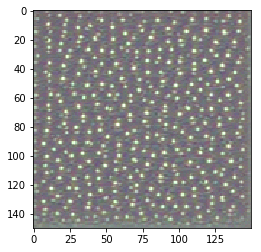

In [11]:
plt.imshow(generate_pattern('block3_conv1', 0))

### It seems that filter 0 in layer block3_conv1 is repsonsive to a polka-dot pattern;

### Now we can visualize every filter in every layer. For simplicity, we'll only look at the first 64 filters in each layer, and you'll only look at the first layer of each convolutional block: (blockx_conv1), arranged on an 8 &times; 8 grid of 64 &times; 64 filter patterns, with some black margins between each filter pattern. 

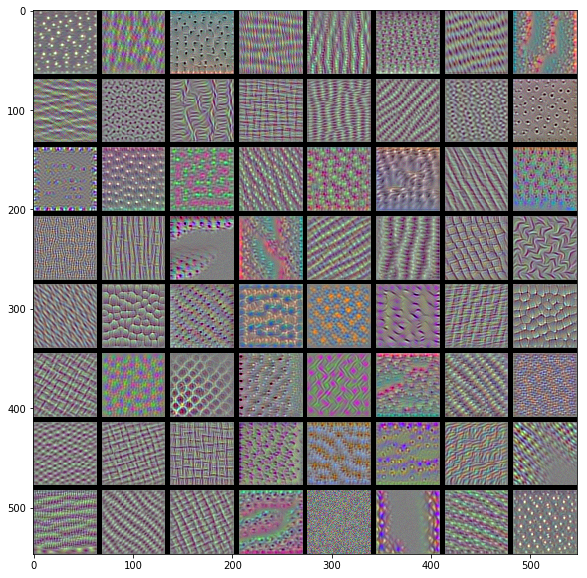

In [25]:
# generate a grid of all filter response patterns in a layer
layer_name = 'block3_conv1'
    
size = 64
margin = 5

# define an empty(black) image to store results
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size = 64)
        filter_img = filter_img / 255
        # put the results in the square (i, j) of the results grid
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start : horizontal_end,
                vertical_start : vertical_end, :] = filter_img

plt.figure(figsize = (10, 10))
plt.imshow(results)

### These visualizations tell us a lot about how convnet layers see the world:
### Each layer in a convet learns a collection of filters such that their inputs can be expressed as a combination of the filters.
### This is similar to how Fourier transform decomposes signals to a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher in the model:

### 1) The filters from the first layer in the *block1_conv1* encode simple directional edges and colors(or colored edges);
### 2) The filters from *block2_conv1* encodes simple textures made from combinations of edges and colors;
### 3) The filters in higher layer begin to resemble textures found in natural images: feathers, eyes, leaves, etc.

## 5.4.3 Visualizing heatmaps of class activation

### This technique is useful for understanding which parts of a given image led a convnet to its final classification decision. This is quite helpful for debugging process of a convnet, particularly of a mistake.

### This category of techniques is called *class activation map* (CAM) visualization, it consists of producing heatmaps of class activation over input images.

### A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration.

### The specific implementation we'll use is the 'Grad-CAM': Gradient-based CAM. It consists of taking the output feature map of a convolutional layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel.

In [19]:
# we demonstrate this technique using VGG16 again

from keras.applications.vgg16 import VGG16

model = VGG16(weights = 'imagenet')
# note you include densely connected classifier on top this time

553467904/553467096 [==============================] - 127s 0us/step


In [29]:
model = load_model('VGG16_with_top.h5')

### Consider the image of two African elephants, let's convert the image into something the VGG16 can read: the model was trained on images of size 224 &times; 224, preprocessed according to a few rules packaged in vgg16.preprocess_input.

### Thus we first load the image and resize it into 224 &times; 224, convert it into a Numpy float32 tensor, and apply these preprocessing rules.

In [30]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/input/elephant.jpg'

img = image.load_img(img_path, target_size = (224,  224))

x = image.img_to_array(img) # float32 Numpy array of shape (224, 224, 3)

x = np.expand_dims(x, axis = 0) # add adimension to transform array into a batch of size (1, 224, 224, 3)

x = preprocess_input(x) # channel-wise color normalization

### We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [32]:
preds = model.predict(x)


### The top three classes predicted for this image are as follows:
### 1) African elephant ---- probability 92.5%
### 2) Tusker ---- probability 7%
### 3) Indian elephant ---- probability 0.4%

### The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponds to the 'African elephant' class, at index 386

In [33]:
np.argmax(preds[0])

386

### To visualize which parts of the image are the most African elephant-like, let's set up the Grad-CAM process

In [34]:
african_elephant_output = model.output[:, 386] # African elephant entry in the prediction vector

# output feature map of last convolutional layer in VGG16: block5_conv3
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis = (0, 1, 2)) 
# vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # multiple each channel in the feature-map array by gradient('how important' channel to the class)

heatmap = np.mean(conv_layer_output_value, axis = -1)

### For visualization, we also normalize the heatmap between 0 and 1

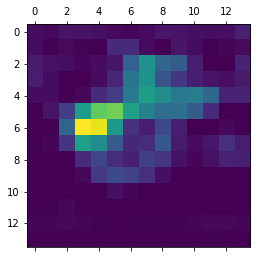

In [35]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.matshow(heatmap)

### Finally, we use the OpenCV to generate an image that superimposes the origianl image on the heat map you just obtained:

In [36]:
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # resize heatmap to be the same size as the origianl one

heatmap = np.uint8(255 *  heatmap) # convert heatmap to RGB

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img # 0.4 here is a heatmap intensity factor

cv2.imwrite('/data/elephant_cam.jpg', superimposed_img)

True

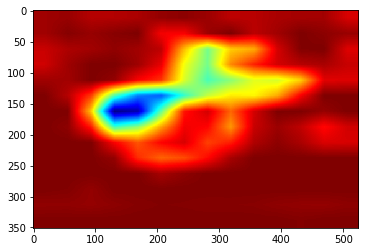

In [39]:
plt.imshow(heatmap)

W0704 00:51:45.605155 140209473054464 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


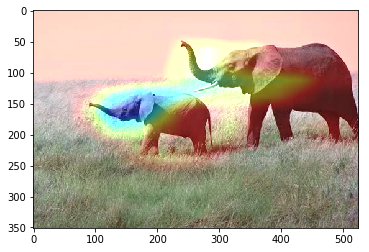

In [43]:
plt.imshow(superimposed_img / 255.)

### This visualization answers two important questions:
### 1) Why did the network think this image contained an African elephant ?
### 2) Where is the African elephant located in the picture ?

### In particular, it's interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.